# Create dictionaries for steamlit app data

use lewagon pyenv for any case

In [1]:
import pandas as pd


---

# original data


In [2]:
raw = pd.read_csv('../raw_data/recs2020_public_v6.csv')


In [10]:
# these columns are currently in the model
model_columns = ["REGIONC", "state_name", "BA_climate", "TYPEHUQ", "STORIES", "YEARMADERANGE", "NCOMBATH", "NHAFBATH", "TOTROOMS"#, "WALLTYPE", "ROOFTYPE"
                 , "WINDOWS",
           "SWIMPOOL", "NUMFRIG", "MICRO", "DISHWASH", "CWASHER", "DRYER", "TVCOLOR", "DESKTOP", "NUMLAPTOP",
           "TELLWORK","HEATHOME", "EQUIPM", "NUMPORTEL", "AIRCOND", "LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8", "SMARTMETER", "SOLAR", "NHSLDMEM", "SQFTEST"
          #,"KWH"
           ]


In [11]:
#! pip install openpyxl


In [12]:
codebook = pd.read_excel(
    '../raw_data/RECS 2020 Codebook for Public File - v6.xlsx'
    , header=1)
codebook.head()


,Variable,Type,Description and Labels,Response Codes,Section
0,DOEID,Num,Unique identifier for each respondent,100001-118496,ADMIN
1,REGIONC,Char,Census Region,Midwest\nNortheast\nSouth\nWest,GEOGRAPHY
2,DIVISION,Char,"Census Division, Mountain Division is divided ...",East North Central\nEast South Central\nMiddle...,GEOGRAPHY
3,STATE_FIPS,Char,State Federal Information Processing System Code,state_dictionary!A1,GEOGRAPHY
4,state_postal,Char,State Postal Code,state_dictionary!A1,GEOGRAPHY


In [13]:
# this is current dict from user input
user_dict = {
  "TYPEHUQ": 1,
  "NHSLDMEM": 1,
  "state_name": "Alabama",
  "REGIONC": "SOUTH",
  "SQFTEST": 240,
  "STORIES": 1,
  "YEARMADERANGE": 1,
  "NCOMBATH": 0,
  "NHAFBATH": 0,
  "TOTROOMS": 1,
  "WALLTYPE": 1,
  "ROOFTYPE": 1,
  "WINDOWS": 1,
  "SWIMPOOL": 1,
  "SOLAR": 1,
  "SMARTMETER": 1,
  "TELLWORK": 1,
  "TELLDAYS": 0,
  "DESKTOP": 0,
  "NUMLAPTOP": 0,
  "TVCOLOR": 0,
  "DISHWASH": 1,
  "MICRO": 0,
  "CWASHER": 1,
  "DRYER": 1,
  "LGTIN1TO4": 0,
  "LGTIN4TO8": 0,
  "LGTINMORE8": 0,
  "AIRCOND": 1,
  "EQUIPM": 3,
  "HEATHOME": 1,
  "NUMPORTEL": 0,
  "NUMPORTAC": 0
}
user_features = pd.DataFrame({k:[v] for k,v in user_dict.items()})
print(f'this columns are too many: {set(user_features.columns).difference(model_columns)}')
print(f'this columns are missing: {set(model_columns).difference(user_features.columns)}')


this columns are too many: {'TELLDAYS', 'NUMPORTAC'}
this columns are missing: {'NUMFRIG', 'BA_climate'}


---

## encode climate

Assign the most frequent climate to state name

Thanks GPT

In [32]:
mycols = ['state_name','BA_climate']
state2climate = raw[mycols].reset_index().groupby(mycols).count().reset_index()
climate_dict = state2climate.groupby('state_name')['BA_climate'].agg(lambda x: x.value_counts().idxmax()).to_dict()


---

## precompute feature dict

In [15]:
# these features were selected by hand (csv imported from xls file on google drive)
#selected = pd.read_csv('../csv/selected_features.csv', index_col=0)

## use functions from Diego instead
selected = codebook.loc[codebook.Variable.isin(model_columns)]
selected.head()


,Variable,Type,Description and Labels,Response Codes,Section
1,REGIONC,Char,Census Region,Midwest\nNortheast\nSouth\nWest,GEOGRAPHY
5,state_name,Char,State Name,state_dictionary!A1,GEOGRAPHY
6,BA_climate,Char,Building America Climate Zone,Cold\nHot-Dry\nHot-Humid\nMarine\nMixed-Dry\nM...,ADMIN
13,TYPEHUQ,Num,Type of housing unit,1 Mobile home\n2 Single-family house detached ...,YOUR HOME
21,STORIES,Num,Number of stories in a single-family home,1 One story\n2 Two stories\n3 Three stories\n4...,YOUR HOME


In [16]:
selected.info()


<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 1 to 294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Variable                33 non-null     object
 1   Type                    33 non-null     object
 2   Description and Labels  33 non-null     object
 3   Response Codes          33 non-null     object
 4   Section                 33 non-null     object
dtypes: object(5)
memory usage: 1.5+ KB


In [17]:
selected.Variable.unique()


array(['REGIONC', 'state_name', 'BA_climate', 'TYPEHUQ', 'STORIES',
       'YEARMADERANGE', 'NCOMBATH', 'NHAFBATH', 'TOTROOMS', 'WALLTYPE',
       'ROOFTYPE', 'WINDOWS', 'SWIMPOOL', 'NUMFRIG', 'MICRO', 'DISHWASH',
       'CWASHER', 'DRYER', 'TVCOLOR', 'DESKTOP', 'NUMLAPTOP', 'TELLWORK',
       'HEATHOME', 'EQUIPM', 'NUMPORTEL', 'AIRCOND', 'LGTIN1TO4',
       'LGTIN4TO8', 'LGTINMORE8', 'SMARTMETER', 'SOLAR', 'NHSLDMEM',
       'SQFTEST'], dtype=object)

In [18]:
# precompute dicts
val_cols = ['Description and Labels','Response Codes']
key_col=['Variable']
label_dict = selected.set_index(key_col)[val_cols[0]].to_dict()
values_dict = selected.set_index(key_col)[val_cols[1]].to_dict()


In [19]:
len(label_dict)


33

In [34]:
# which things in which section
#sections = list(selected.Section.unique())

section_df = (codebook[['Variable','Section']]
                .groupby('Section')
                .agg(lambda x: list(x))
                .reset_index()
                )
section_df.head()


,Section,Variable
0,ADMIN,"[DOEID, BA_climate, IECC_climate_code, UATYP10]"
1,AIR CONDITIONING,"[AIRCOND, COOLAPT, ACEQUIPM_PUB, ACEQUIPAGE, A..."
2,APPLIANCES,"[NUMFRIG, SIZRFRI1, TYPERFR1, AGERFRI1, ICE, S..."
3,ELECTRONICS,"[TVCOLOR, TVSIZE1, TVTYPE1, TVUSE1, TVONWD1, T..."
4,ENERGY ASSISTANCE,"[SCALEB, SCALEG, SCALEE, PAYHELP, NOHEATBROKE,..."


#### Which feature belongs to each section

In [35]:
section_dict = section_df.set_index('Section')['Variable'].to_dict()


---
## Define feature types 

In [22]:
# purely selectbox features
# like 'SOUTH'
selectbox_features = selected['Variable'][ (selected['Response Codes'].str.contains('\n')) & (selected['Type']=='Char')].to_list()
selectbox_features.remove('REGIONC')
selectbox_features.remove('BA_climate') # inferred
print(f'selectbox_features={selectbox_features}')

# purely numeric features
# TODO extract range and put reasonable defaults
# like '0 - 90' or '0-90'
numeric_features = selected['Variable'][selected['Response Codes'].str.match('[0-9]+\s*-\s*[0-9]+$')].to_list()
print(f'numeric_features={numeric_features}')

# features whihc are numeric but are input through dropdown selectbox
# like '1 - 9\n-2 Not applicable'
numeric_features_dropdown = selected['Variable'][selected['Response Codes'].str.match('[0-9]+\s*-\s*[0-9]+\n')].to_list()
print(f'numeric_features_dropdown = {numeric_features_dropdown}')

# numeric selectbox features
# like "1 Yes\n0 No\n-4 Don't Know"
num_checkbox_features = selected['Variable'][ (selected['Response Codes'].str.contains('\n')) & (selected['Type']=='Num')].to_list()
# quick and ugly fix
for feature in numeric_features_dropdown:
    num_checkbox_features.remove(feature)
print(f'num_checkbox_features = {num_checkbox_features}')


selectbox_features=[]
numeric_features=['NCOMBATH', 'NHAFBATH', 'TOTROOMS', 'NUMFRIG', 'MICRO', 'TVCOLOR', 'DESKTOP', 'NUMLAPTOP', 'LGTIN1TO4', 'LGTIN4TO8', 'LGTINMORE8', 'NHSLDMEM', 'SQFTEST']
numeric_features_dropdown = ['NUMPORTEL']
num_checkbox_features = ['TYPEHUQ', 'STORIES', 'YEARMADERANGE', 'WALLTYPE', 'ROOFTYPE', 'WINDOWS', 'SWIMPOOL', 'DISHWASH', 'CWASHER', 'DRYER', 'TELLWORK', 'HEATHOME', 'EQUIPM', 'AIRCOND', 'SMARTMETER', 'SOLAR']


---
### create mappings for numeric selectbox features

In [23]:
mapped_features={}
for feature in num_checkbox_features:
    mapped_features[feature]=dict(val.split(' ', 1)[::-1] for val in values_dict.get(feature).split('\n'))
for feature in numeric_features_dropdown:
    str_range, text  = values_dict[feature].split('\n')
    d = {str(k):str(k) for k in range(int(str_range.split(' - ')[-1])+1)}
    d.update({text.split(' ',1)[1]:text.split(' ',1)[0]})
    mapped_features[feature] = d


In [48]:
#mapped_features #direction : from text to int


In [ ]:
#yesno_features =


---

## create state dictionary

In [25]:
state_dictionary = pd.read_csv('../csv/state_dictionary.csv')
state_dictionary.head(1)


,STATE_FIPS,state_postal,state_name
0,1,AL,Alabama


In [54]:
#state_dictionary.drop(columns='STATE_FIPS').set_index('state_postal').to_dict('state_name')

#{code:state for code, state in zip(state_dictionary.state_postal, state_dictionary.state_name)}
# faster
#df.set_index(KEY).to_dict()[VALUE]
#https://stackoverflow.com/questions/17426292/how-to-create-a-dictionary-of-two-pandas-dataframe-columns#17426500


In [42]:
states = state_dictionary.set_index('state_postal')['state_name'].to_dict()


In [39]:
# map region from state
state_to_region = raw[['state_name','REGIONC']].drop_duplicates().set_index('state_name')['REGIONC'].to_dict()


In [53]:
print(f'label_dict = {label_dict}')
print(f'values_dict = {values_dict}')
print('# U.S. states selector')
print(f'states ={states}')
print('# state to region mapper')
print(f'state_to_region={state_to_region}')
print('# state to most frequent climate mapper')
print(f'climate_dict = {climate_dict}')
print('# section to features mapper')
print(f'section_dict = {section_dict}')
#print('-------------------')


label_dict = {'REGIONC': 'Census Region', 'state_name': 'State Name', 'BA_climate': 'Building America Climate Zone', 'TYPEHUQ': 'Type of housing unit', 'STORIES': 'Number of stories in a single-family home', 'YEARMADERANGE': 'Range when housing unit was built', 'NCOMBATH': 'Number of full bathrooms (top-coded)', 'NHAFBATH': 'Number of half bathrooms (top-coded)', 'TOTROOMS': 'Total number of rooms in the housing unit, excluding bathrooms; a derived variable', 'WALLTYPE': 'Major outside wall material', 'ROOFTYPE': "Major roofing material; 'Not applicable' applies to apartment buildings with 5 or more units", 'WINDOWS': 'Number of windows', 'SWIMPOOL': 'Has swimming pool', 'NUMFRIG': 'Number of refrigerators used', 'MICRO': 'Number of microwaves ', 'DISHWASH': 'Has dishwasher', 'CWASHER': 'Has clothes washer in home', 'DRYER': 'Has clothes dryer in home', 'TVCOLOR': 'Number of televisions used', 'DESKTOP': 'Number of desktop computers used', 'NUMLAPTOP': 'Number of laptop computers used'

In [58]:
any([x in [1,2,3] for x in [1,2]])


True

---

#### delete Non applicable and Dont know

In [62]:
# loop over dictionary of dictionaries
for feature, value in mapped_features.items():
    for key in ["Not applicable", "Don't Know"]:
        if key in value.keys():
            print(feature,value)
            del value[key]
            print(feature,value)


STORIES {'One story': '1', 'Two stories': '2', 'Three stories': '3', 'Four or more stories': '4', 'Split-level': '5', 'Not applicable': '-2'}
STORIES {'One story': '1', 'Two stories': '2', 'Three stories': '3', 'Four or more stories': '4', 'Split-level': '5'}
ROOFTYPE {'Ceramic or clay tiles': '1', 'Wood shingles/shakes': '2', 'Metal': '3', 'Slate or synthetic slate': '4', 'Shingles (composition or asphalt)': '5', 'Concrete tiles': '6', 'Other': '99', 'Not applicable': '-2'}
ROOFTYPE {'Ceramic or clay tiles': '1', 'Wood shingles/shakes': '2', 'Metal': '3', 'Slate or synthetic slate': '4', 'Shingles (composition or asphalt)': '5', 'Concrete tiles': '6', 'Other': '99'}
SWIMPOOL {'Yes': '1', 'No': '0', 'Not applicable': '-2'}
SWIMPOOL {'Yes': '1', 'No': '0'}
EQUIPM {'Central furnace ': '3', 'Steam or hot water system with radiators or pipes ': '2', 'Central heat pump': '4', 'Ductless heat pump, also known as a “mini-split”': '13', 'Built-in electric units installed in walls, ceilings, bas

In [63]:
print(f'mapped_features = {mapped_features}')


mapped_features = {'TYPEHUQ': {'Mobile home': '1', 'Single-family house detached from any other house ': '2', 'Single-family house attached to one or more other houses (for example: duplex, row house, or townhome)': '3', 'Apartment in a building with 2 to 4 units': '4', 'Apartment in a building with 5 or more units': '5'}, 'STORIES': {'One story': '1', 'Two stories': '2', 'Three stories': '3', 'Four or more stories': '4', 'Split-level': '5'}, 'YEARMADERANGE': {'Before 1950': '1', '1950 to 1959': '2', '1960 to 1969': '3', '1970 to 1979': '4', '1980 to 1989': '5', '1990 to 1999': '6', '2000 to 2009': '7', '2010 to 2015': '8', '2016 to 2020': '9'}, 'WALLTYPE': {'Brick': '1', 'Wood': '2', 'Siding (aluminum, fiber cement, vinyl, or steel) ': '3', 'Stucco': '4', 'Shingle (composition)': '5', 'Stone ': '6', 'Concrete block ': '7', 'Other': '99'}, 'ROOFTYPE': {'Ceramic or clay tiles': '1', 'Wood shingles/shakes': '2', 'Metal': '3', 'Slate or synthetic slate': '4', 'Shingles (composition or asp

In [67]:
# yes no features - use toggle!
yes_no_features = []
for feature, value in mapped_features.items():
    if all([key in value.keys() for key in ['Yes','No']]):
            #print(feature,value)
            yes_no_features.append(feature)
print(f'yes_no_features = {yes_no_features}')


yes_no_features = ['SWIMPOOL', 'DISHWASH', 'CWASHER', 'DRYER', 'TELLWORK', 'HEATHOME', 'AIRCOND', 'SMARTMETER', 'SOLAR']


---

## final dataframe for testing

In [29]:
X_new = pd.DataFrame.from_dict({'feat1':[1], 'feat2':[-2]},orient='columns')
X_new


,feat1,feat2
0,1,-2


#### For the range around average estimate: 

<Axes: >

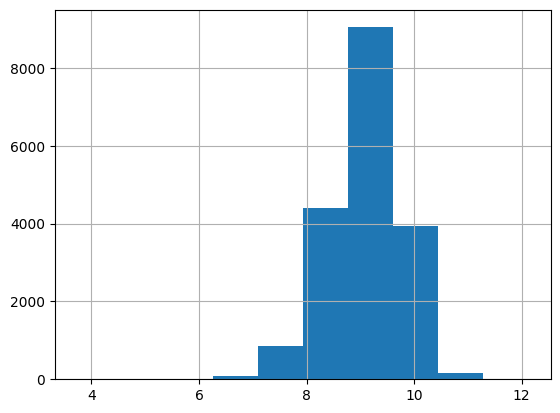

In [78]:
import numpy as np
y_log = np.log(raw.KWH)
y_log.hist()


In [80]:
np.exp(y_log.mean())


8870.991562197461

In [85]:
np.exp(y_log.quantile(0))


42.01

In [93]:
pd.DataFrame(y_log.describe()).drop('count', axis=0).assign(kwh=lambda x:np.exp(x.KWH))


,KWH,kwh
mean,9.090542,8870.991562
std,0.665891,1.946224
min,3.737908,42.010000
25%,8.686424,5921.970000
50%,9.142750,9346.434990
75%,9.557846,14155.327346
max,12.123244,184101.840000


---

### Prices dict from Diego

In [5]:
prices_per_state={'Alabama': 0.1483,
 'Alaska': 0.245,
 'Arizona': 0.1439,
 'Arkansas': 0.1267,
 'California': 0.2999,
 'Colorado': 0.1503,
 'Connecticut': 0.2925,
 'Delaware': 0.1583,
 'District of Columbia': 0.1628,
 'Florida': 0.1551,
 'Georgia': 0.1401,
 'Hawaii': 0.4152,
 'Idaho': 0.116,
 'Illinois': 0.1479,
 'Indiana': 0.141,
 'Iowa': 0.1403,
 'Kansas': 0.1346,
 'Kentucky': 0.1243,
 'Louisiana': 0.1139,
 'Maine': 0.2686,
 'Maryland': 0.1696,
 'Massachusetts': 0.28,
 'Michigan': 0.1935,
 'Minnesota': 0.1529,
 'Mississippi': 0.1305,
 'Missouri': 0.1423,
 'Montana': 0.1318,
 'Nebraska': 0.1239,
 'Nevada': 0.1694,
 'New Hampshire': 0.2331,
 'New Jersey': 0.1802,
 'New Mexico': 0.1525,
 'New York': 0.2323,
 'North Carolina': 0.1409,
 'North Dakota': 0.1277,
 'Ohio': 0.1568,
 'Oklahoma': 0.1325,
 'Oregon': 0.1313,
 'Pennsylvania': 0.1801,
 'Rhode Island': 0.2694,
 'South Carolina': 0.1452,
 'South Dakota': 0.1305,
 'Tennessee': 0.1185,
 'Texas': 0.1458,
 'Utah': 0.1185,
 'Vermont': 0.2121,
 'Virginia': 0.1479,
 'Washington': 0.1138,
 'West Virginia': 0.1438,
 'Wisconsin': 0.1732,
 'Wyoming': 0.1264}

print(f'price_per_state = {prices_per_state}')


price_per_state = {'Alabama': 0.1483, 'Alaska': 0.245, 'Arizona': 0.1439, 'Arkansas': 0.1267, 'California': 0.2999, 'Colorado': 0.1503, 'Connecticut': 0.2925, 'Delaware': 0.1583, 'District of Columbia': 0.1628, 'Florida': 0.1551, 'Georgia': 0.1401, 'Hawaii': 0.4152, 'Idaho': 0.116, 'Illinois': 0.1479, 'Indiana': 0.141, 'Iowa': 0.1403, 'Kansas': 0.1346, 'Kentucky': 0.1243, 'Louisiana': 0.1139, 'Maine': 0.2686, 'Maryland': 0.1696, 'Massachusetts': 0.28, 'Michigan': 0.1935, 'Minnesota': 0.1529, 'Mississippi': 0.1305, 'Missouri': 0.1423, 'Montana': 0.1318, 'Nebraska': 0.1239, 'Nevada': 0.1694, 'New Hampshire': 0.2331, 'New Jersey': 0.1802, 'New Mexico': 0.1525, 'New York': 0.2323, 'North Carolina': 0.1409, 'North Dakota': 0.1277, 'Ohio': 0.1568, 'Oklahoma': 0.1325, 'Oregon': 0.1313, 'Pennsylvania': 0.1801, 'Rhode Island': 0.2694, 'South Carolina': 0.1452, 'South Dakota': 0.1305, 'Tennessee': 0.1185, 'Texas': 0.1458, 'Utah': 0.1185, 'Vermont': 0.2121, 'Virginia': 0.1479, 'Washington': 0.113